# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from utils_clustering import (visualize_dimensionality_reduction, plot_comparing_avr_clusters, 
                              plot_dendrogram)
import umap
from minisom import MiniSom

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", None)

In [2]:
%cd ..
data_for_analysis = pd.read_csv('datasets/For_analysis_non_scaled_preprocessed_data.csv', index_col = 0)
classified_data = data_for_analysis[data_for_analysis.Final_Cluster != 'Unspecified']
unclassified_data = data_for_analysis[data_for_analysis.Final_Cluster == 'Unspecified']
data_for_modelling = pd.read_csv('datasets/scaled_preprocessed_data.csv', index_col = 0)
data_for_modelling = data_for_modelling[data_for_modelling.index.isin(unclassified_data.index)]
%cd Modelling

c:\Users\luisb\OneDrive\Documentos\uni\Year 2\Semester 2\Machine learning 2\ML2_project
c:\Users\luisb\OneDrive\Documentos\uni\Year 2\Semester 2\Machine learning 2\ML2_project\Modelling


# Introduction

This notebook will detail the process of obtaining the clusters that best describe our data. 

Firstly, we'll just take a look at the datasets that will be used:
+ **classified_data** includes customers that have been assigned to a cluster and will be used at the end for a detailed analysis of our final clusters (only the fishermen, at this point);
+ **unclassified_data** includes customers that haven't been assigned a final cluster, this is the dataset that we will use to evaluate different clustering solutions.
+ Finally, the **data_for_modelling** is the scaled data we will use to train our models in cases where we don't wish to perform any aditional transformations to the data.

In [3]:
classified_data

,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,customer_name,Bsc.,Hsc.,Msc.,Phd.,Final_Cluster
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48086,0,0,1,1,23.32,0.08,7.00,0.39,0.45,0.18,0.14,75.32,0.13,0.00,0.00,14.00,24.77,58.00,1.00,0.00,64304.00,13.00,Charles`s Fishy,0,1,0,0,Fishermen
31838,0,0,1,1,22.86,0.17,9.00,0.53,0.74,0.06,0.05,75.42,0.17,0.00,0.00,24.00,0.00,61.00,0.00,1.00,60528.00,13.00,Ursula`s Fishy,0,1,0,0,Fishermen
41519,0,0,0,1,27.14,0.31,9.00,0.21,0.52,0.15,0.16,71.23,0.27,0.00,0.00,33.00,39.93,68.00,0.00,0.00,54085.00,9.00,Lindsay`s Fishy,0,1,0,0,Fishermen
41076,0,0,0,1,29.92,0.71,12.00,0.82,0.50,0.14,0.35,67.40,0.16,0.00,0.00,34.00,28.27,82.00,0.00,0.00,50499.00,14.00,Carol`s Fishy,0,1,0,0,Fishermen
43120,0,0,1,1,29.64,0.35,9.00,0.55,0.61,0.19,0.13,68.49,0.03,0.00,0.00,20.00,39.62,44.00,0.00,0.00,57166.00,13.00,Rosetta`s Fishy,0,1,0,0,Fishermen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24463,0,0,1,1,28.25,0.13,17.00,0.16,0.98,0.15,0.09,70.00,0.23,0.00,0.00,7.00,22.83,68.00,0.00,1.00,57980.00,10.00,Stephanie`s Fishy,0,1,0,0,Fishermen
12487,0,0,0,1,29.26,0.29,17.00,0.69,0.46,0.24,0.18,68.77,0.12,0.00,0.00,29.00,31.52,51.00,1.00,1.00,59522.00,21.00,Derrick`s Fishy,0,1,0,0,Fishermen
14727,0,0,1,1,25.78,0.29,9.00,0.94,0.71,0.17,0.10,72.77,0.18,0.00,0.00,14.00,36.52,39.00,1.00,1.00,55018.00,14.00,Tyler`s Fishy,0,1,0,0,Fishermen


In [4]:
unclassified_data

,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,customer_name,Bsc.,Hsc.,Msc.,Phd.,Final_Cluster
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
39634,1,1,1,2,43.22,16.78,17.00,1.14,1.43,2.23,5.26,9.58,5.13,9.32,5.93,32.00,7.22,60.00,1.00,0.00,42359.00,14.00,David Frink,0,1,0,0,Unspecified
43460,1,0,1,2,30.57,8.13,8.00,2.10,2.28,7.42,6.51,11.73,12.89,6.27,12.11,2566.00,20.62,36.00,0.00,0.00,16407.00,10.00,Belinda Terry,0,1,0,0,Unspecified
23937,0,1,1,3,17.52,23.04,10.00,1.70,4.82,9.79,2.52,13.28,7.39,8.51,11.42,1282.00,13.62,55.00,0.00,1.00,17675.00,15.00,Evelyn Calico,0,1,0,0,Unspecified
2431,0,0,0,1,67.15,1.28,17.00,0.95,1.56,0.37,1.77,0.94,0.33,0.00,25.65,70.00,21.59,83.00,0.00,1.00,16121.00,17.00,Ora Boggess,0,1,0,0,Unspecified
10090,0,0,0,1,13.30,10.88,17.20,0.15,0.63,54.05,1.03,3.28,11.20,4.25,1.22,4.00,18.10,23.00,1.00,1.00,5241.00,0.00,Lonnie Hopson,0,1,0,0,Unspecified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,1,1,0,1,24.10,21.09,17.00,2.27,2.48,2.14,5.26,12.67,5.86,14.70,9.43,14.00,23.33,41.00,0.00,0.00,29835.00,8.00,Amelia Crawford,0,1,0,0,Unspecified
24856,1,1,1,1,28.05,28.67,12.00,1.50,1.39,3.75,6.51,9.72,4.05,9.56,6.80,25.00,6.10,32.00,0.00,1.00,40071.00,10.00,Silvia Ramos,0,1,0,0,Unspecified
21373,0,0,0,1,31.98,1.27,12.00,1.53,2.22,0.23,1.75,0.75,0.94,0.00,59.34,44.00,9.77,30.00,0.00,0.00,18946.00,7.00,Addie Coronel,0,1,0,0,Unspecified


In [5]:
data_for_modelling

,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure
customer_id,,,,,,,,,,,,,,,,,,,,,,
39634,0.00,0.00,0.00,1.00,0.42,0.68,0.57,-0.43,-0.72,-0.20,0.06,0.22,-0.35,0.57,-0.56,-0.50,-0.67,0.22,1.00,-1.00,2.44,0.17
43460,0.00,-1.00,0.00,1.00,-0.53,0.02,-0.71,-0.19,-0.44,1.19,0.26,0.45,0.97,0.03,0.61,5.26,0.00,-0.53,0.00,-1.00,0.32,-0.50
23937,-1.00,0.00,0.00,2.00,-1.50,1.16,-0.43,-0.29,0.40,1.83,-0.37,0.61,0.04,0.42,0.48,2.34,-0.35,0.06,0.00,0.00,0.43,0.33
2431,-1.00,-1.00,-1.00,0.00,2.21,-0.50,0.57,-0.48,-0.67,-0.70,-0.49,-0.71,-1.16,-1.08,3.18,-0.41,0.05,0.94,0.00,0.00,0.30,0.67
10090,-1.00,-1.00,-1.00,0.00,-1.82,0.23,0.60,-0.68,-0.98,13.70,-0.61,-0.46,0.68,-0.33,-1.46,-0.56,-0.12,-0.94,1.00,0.00,-0.59,-2.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,0.00,0.00,-1.00,0.00,-1.01,1.01,0.57,-0.14,-0.37,-0.22,0.06,0.55,-0.22,1.52,0.10,-0.54,0.14,-0.38,0.00,-1.00,1.42,-0.83
24856,0.00,0.00,0.00,0.00,-0.72,1.59,-0.14,-0.34,-0.73,0.21,0.26,0.23,-0.53,0.61,-0.40,-0.52,-0.72,-0.66,0.00,0.00,2.26,-0.50
21373,-1.00,-1.00,-1.00,0.00,-0.42,-0.50,-0.14,-0.33,-0.46,-0.74,-0.49,-0.73,-1.06,-1.08,9.58,-0.47,-0.54,-0.72,0.00,-1.00,0.53,-1.00


# Modelling

# K-Means - Original Data


The first clustering solution we will try is a KMeans, firstly we'll plot the elbow curve to find the optimal number of clusters.

  File "c:\Users\luisb\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


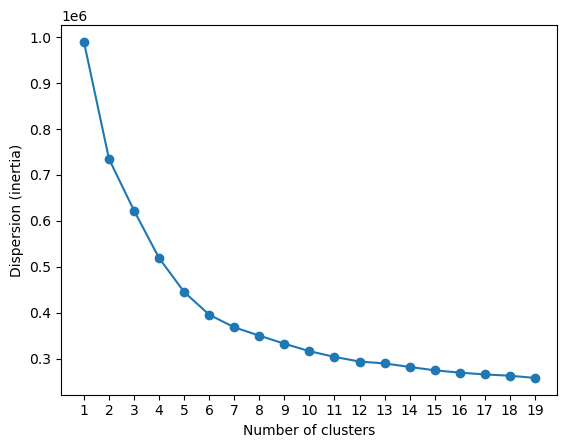

In [6]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data_for_modelling)
    dispersion.append(kmeans.inertia_)
plt.plot(range(1, 20), dispersion, marker='o')
plt.xticks(range(1, 20))
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

Looking at the elbow curve, we believe 9 clusters gives a the best compromise as going with more isn't going to significantly decrease the inertia of the model, but going lower might yield big increases in this inertia. We will now fit the model to our data.

In [7]:
kmeans = KMeans(n_clusters=9, random_state=0)
unclassified_data['cluster_kmeans'] =  kmeans.fit_predict(data_for_modelling)


In [8]:
kmeans.inertia_

332866.5443421775

In [9]:
unclassified_data['cluster_kmeans'].value_counts()

cluster_kmeans
0    7405
5    7323
7    5649
2    5387
6    5285
8    5121
1    4146
4    2007
3     920
Name: count, dtype: int64

In [10]:
d_kmeans = {5285: 'Oldest Customers', 4146: 'Pet lovers', 5121: 'Lots of kids', 7405: 'Vegetarians',
           5387: 'Young, lots of electronics', 2007: '???', 5649: 'Gamers', 7323: 'Promotion lovers', 920: 'Young party people'}
cluster_centroids_kmeans = unclassified_data.drop(['customer_name', 'Final_Cluster'], axis = 1).groupby('cluster_kmeans').mean().reset_index()
cluster_centroids_kmeans['cluster_kmeans'] = cluster_centroids_kmeans['cluster_kmeans'].apply(lambda row : d_kmeans[unclassified_data['cluster_kmeans'].value_counts()[row]])
cluster_centroids_kmeans

,cluster_kmeans,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.
0,Vegetarians,1.00,0.43,0.51,1.19,49.41,6.57,13.74,16.49,5.00,2.06,0.33,0.36,8.24,3.48,8.36,209.63,20.22,55.02,0.49,0.50,6084.89,12.91,0.13,0.61,0.13,0.12
1,Pet lovers,0.00,0.01,0.51,1.00,45.42,0.78,11.87,0.98,2.45,0.20,1.00,1.00,0.40,0.01,47.81,51.86,19.86,55.30,0.49,0.20,21588.86,12.94,0.00,1.00,0.00,0.00
2,"Young, lots of electronics",0.54,0.76,0.50,1.33,37.64,18.71,14.82,3.06,3.13,3.42,6.28,7.48,6.44,7.07,7.03,486.74,19.88,42.67,0.49,0.54,12907.97,10.36,0.10,0.69,0.10,0.10
3,Young party people,0.32,0.02,0.04,1.39,15.14,9.31,18.64,1.82,8.84,40.98,3.33,3.53,9.35,5.66,2.14,65.24,14.88,25.06,0.49,0.51,5527.65,2.52,0.02,0.95,0.01,0.01
4,???,0.87,0.70,0.51,2.00,19.30,8.11,14.27,8.34,10.96,11.57,9.05,8.50,9.06,7.53,8.00,369.81,19.41,51.20,0.52,0.40,5822.78,11.54,0.03,0.91,0.03,0.03
5,Promotion lovers,0.55,0.99,1.00,3.14,37.56,3.95,12.25,3.83,5.59,5.63,7.42,9.03,9.04,7.29,10.98,393.81,50.51,55.62,0.51,0.78,5712.90,13.06,0.04,0.90,0.03,0.04
6,Oldest Customers,1.01,0.85,1.07,1.98,29.40,11.55,9.87,2.04,3.58,6.26,6.10,11.51,12.00,6.08,11.89,1060.26,20.03,56.24,0.50,0.77,15847.70,15.48,0.09,0.73,0.08,0.10
7,Gamers,1.00,1.00,0.50,1.39,35.54,20.19,13.63,1.30,1.56,2.63,5.22,10.40,5.21,10.44,7.84,100.55,6.95,55.23,0.50,0.50,39100.94,12.86,0.13,0.60,0.13,0.14
8,Lots of kids,3.86,2.11,1.00,1.11,37.68,14.87,17.69,3.79,3.81,2.28,7.59,7.58,7.53,7.58,7.57,515.89,19.99,55.68,0.49,0.60,13352.31,13.01,0.07,0.80,0.06,0.07


Above we can see the dataframe corresponding to the centroids of our clusters, a dictionary is used to link the output of KMeans to interpretable names for clusters (random_state isn't enough as cluster numbers change, despite the clusters themselves remaining identical across kernels). A more detailed plot comparing different cluster means to overal means for all variables is available below and allows us to get a better understanding of the defining characteristic of our clusters and thus their names.

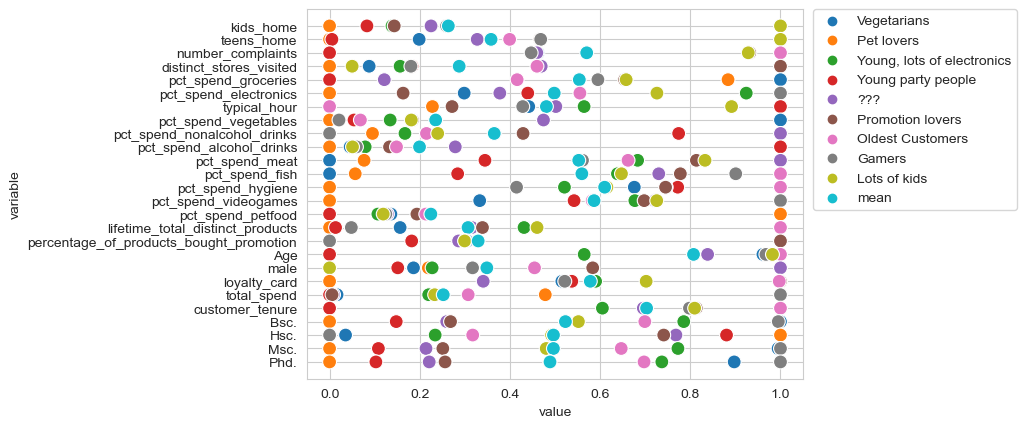

In [11]:
plot_comparing_avr_clusters(clusters_centroids_data = cluster_centroids_kmeans, colum_to_keep = 'cluster_kmeans')

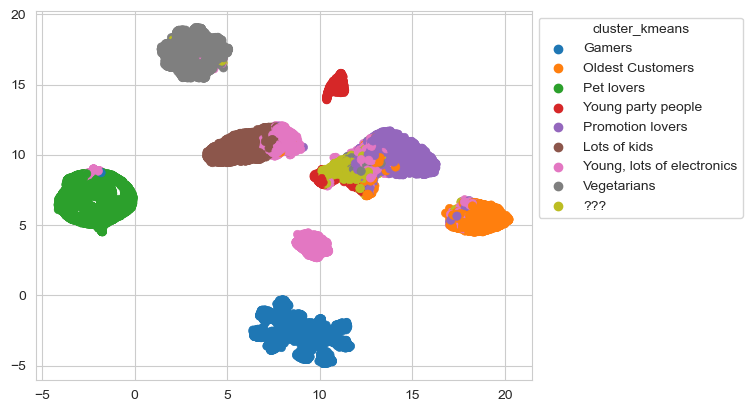

In [12]:
umap_original = umap.UMAP(n_neighbors = 10, random_state = 0).fit_transform(data_for_modelling)
visualize_dimensionality_reduction(umap_original, unclassified_data['cluster_kmeans'].apply(lambda row : d_kmeans[unclassified_data['cluster_kmeans'].value_counts()[row]]))


The UMAP dimensionality reduction allows us to get a better idea of the performance of our model. In this case, we can clearly identify some of the clusters, but there large areas of uncertainty. For this reason we won't use this solution to assign final clusters to any of our customers. 

# Data Transformation

This transformation regards transforming kids_home and teens_home into binary variables, where a 0 means no kids or teens and 1 means there are kids or teens regardless of the number. To do this we will have to use our unscaled data (unclassified_data) and filter out the columns we don't use for modelling (previous clustering tests, education variables, customer name and the final cluster) then perform the transformation of the columns and then rescale the data using RobustScaler again.

In [13]:
adjust = unclassified_data.columns[unclassified_data.columns.str.endswith('home')]
cluster_vars = list(unclassified_data.columns[unclassified_data.columns.str.startswith('cluster')])
data_for_modelling_adjust = unclassified_data.drop([*cluster_vars, 'Bsc.', 'Hsc.', 'Msc.', 'Phd.', 'customer_name', 'Final_Cluster'], axis = 1).copy()
for var in adjust:
    data_for_modelling_adjust[var] = (data_for_modelling_adjust[var] != 0) + 0

In [14]:
scaler = RobustScaler()

In [15]:
data_for_modelling_adjust_scaled = pd.DataFrame(scaler.fit_transform(data_for_modelling_adjust), index = data_for_modelling_adjust.index, columns = data_for_modelling_adjust.columns)

In [16]:
data_for_modelling_adjust_scaled

,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure
customer_id,,,,,,,,,,,,,,,,,,,,,,
39634,0.00,0.00,0.00,1.00,0.42,0.67,0.57,-0.44,-0.73,-0.21,0.05,0.23,-0.36,0.56,-0.57,-0.51,-0.67,0.22,1.00,-1.00,2.50,0.17
43460,0.00,-1.00,0.00,1.00,-0.54,0.01,-0.71,-0.20,-0.45,1.19,0.25,0.46,0.97,0.02,0.60,5.25,0.01,-0.53,0.00,-1.00,0.34,-0.50
23937,-1.00,0.00,0.00,2.00,-1.53,1.15,-0.43,-0.30,0.39,1.83,-0.38,0.63,0.03,0.42,0.47,2.33,-0.34,0.06,0.00,0.00,0.44,0.33
2431,-1.00,-1.00,-1.00,0.00,2.22,-0.51,0.57,-0.49,-0.68,-0.71,-0.50,-0.70,-1.18,-1.10,3.19,-0.42,0.06,0.94,0.00,0.00,0.31,0.67
10090,-1.00,-1.00,-1.00,0.00,-1.84,0.22,0.60,-0.69,-0.99,13.76,-0.62,-0.45,0.68,-0.34,-1.47,-0.57,-0.12,-0.94,1.00,0.00,-0.59,-2.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,0.00,0.00,-1.00,0.00,-1.03,1.00,0.57,-0.15,-0.38,-0.23,0.05,0.56,-0.23,1.53,0.09,-0.55,0.15,-0.38,0.00,-1.00,1.45,-0.83
24856,0.00,0.00,0.00,0.00,-0.73,1.58,-0.14,-0.35,-0.74,0.20,0.25,0.24,-0.54,0.61,-0.41,-0.52,-0.72,-0.66,0.00,0.00,2.30,-0.50
21373,-1.00,-1.00,-1.00,0.00,-0.43,-0.51,-0.14,-0.34,-0.47,-0.75,-0.50,-0.73,-1.07,-1.10,9.61,-0.48,-0.54,-0.72,0.00,-1.00,0.55,-1.00


This is the dataset we will use going forward, because it provides us with better results, this is apparent in the KMeans model below.

# K-Means - Transformed Data


The second model we're going to test is still a KMeans but we're going use the transformed data from above. 

We will now, once again, plot the elbow curve.

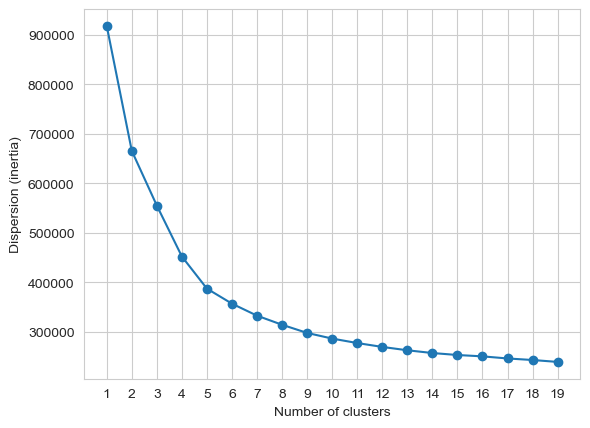

In [17]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data_for_modelling_adjust_scaled)
    dispersion.append(kmeans.inertia_)
plt.plot(range(1, 20), dispersion, marker='o')
plt.xticks(range(1, 20))
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

We again choose 9 as our number of clusters, for the same reason as before and also to give us a more direct comparison of the effectiveness of our transformations.

In [18]:
kmeans_adjust = KMeans(n_clusters=9, random_state=0)
unclassified_data['cluster_kmeans_adjust'] =  kmeans_adjust.fit_predict(data_for_modelling_adjust_scaled)

In [19]:
kmeans_adjust.inertia_

298084.79512375174

In [20]:
unclassified_data['cluster_kmeans_adjust'].value_counts()

cluster_kmeans_adjust
2    10722
4     7408
8     7184
7     5644
0     5147
1     2472
6     2003
3     1749
5      914
Name: count, dtype: int64

In [21]:
d_kmeans_adjust = {5644 : 'Gamers', 7184 : 'Promotion lovers', 2472: 'Pet lovers 2', 5147 : 'Oldest Customers', 
          7408 : 'Vegetarians', 914 : 'Young party poeple', 2003 : '??????', 1749 : 'Pet lovers 1', 10722 : 'Lots of kids'}
cluster_centroids_kmeans_adjust = unclassified_data.drop(['customer_name', 'Final_Cluster'], axis = 1).groupby('cluster_kmeans_adjust').mean().reset_index()
cluster_centroids_kmeans_adjust['cluster_kmeans_adjust'] = cluster_centroids_kmeans_adjust['cluster_kmeans_adjust'].apply(lambda row : d_kmeans_adjust[unclassified_data['cluster_kmeans_adjust'].value_counts()[row]])
cluster_centroids_kmeans_adjust

,cluster_kmeans_adjust,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans
0,Oldest Customers,1.01,0.84,1.05,2.00,29.25,11.69,9.78,2.00,3.57,6.27,6.07,11.54,12.02,6.06,11.92,1082.55,19.94,55.73,0.50,0.78,15980.05,15.40,0.09,0.72,0.09,0.10,5.96
1,Pet lovers 2,0.00,0.01,0.50,1.00,54.33,0.76,11.93,0.93,2.35,0.20,0.95,0.95,0.39,0.01,39.17,51.69,19.89,55.15,0.48,0.21,22449.67,12.96,0.00,1.00,0.00,0.00,1.04
2,Lots of kids,2.13,1.42,0.76,1.22,37.40,16.62,16.19,3.45,3.52,2.91,7.00,7.63,7.10,7.38,7.29,498.73,20.20,49.54,0.49,0.58,12949.84,11.80,0.09,0.75,0.08,0.08,4.98
3,Pet lovers 1,0.00,0.01,0.52,1.00,33.91,0.83,11.78,1.05,2.61,0.21,1.07,1.07,0.41,0.00,58.89,52.19,19.82,55.60,0.51,0.19,20257.87,12.95,0.00,1.00,0.00,0.00,1.00
4,Vegetarians,1.00,0.43,0.51,1.19,49.42,6.57,13.74,16.49,5.00,2.07,0.33,0.36,8.23,3.47,8.35,209.37,20.20,54.96,0.49,0.50,6087.26,12.89,0.13,0.61,0.13,0.12,0.01
5,Young party poeple,0.32,0.02,0.04,1.39,15.13,9.31,18.64,1.82,8.78,41.08,3.33,3.53,9.32,5.65,2.14,65.41,14.88,25.07,0.49,0.51,5528.55,2.52,0.02,0.95,0.01,0.01,3.00
6,??????,0.86,0.69,0.52,2.00,19.17,8.16,14.29,8.29,10.93,11.75,9.00,8.50,9.10,7.54,7.97,367.22,19.51,51.02,0.52,0.39,5810.27,11.46,0.03,0.91,0.03,0.03,3.99
7,Gamers,1.00,1.00,0.50,1.39,35.52,20.21,13.63,1.30,1.56,2.63,5.22,10.40,5.21,10.45,7.83,100.55,6.94,55.22,0.50,0.50,39112.63,12.86,0.13,0.60,0.13,0.14,7.00
8,Promotion lovers,0.55,0.99,1.00,3.18,37.56,3.96,12.21,3.82,5.58,5.67,7.40,9.03,9.03,7.26,11.00,394.85,50.76,55.47,0.51,0.78,5729.51,13.02,0.04,0.90,0.03,0.04,4.99


Above we  see the dataframe corresponding to the centroids of our clusters, a dictionary is used to link the output of KMeans to interpretable names for clusters (random_state isn't enough as cluster numbers change, despite the clusters themselves remaining identical across kernels). A more detailed plot comparing different cluster means to overal means for all variables is available below and allows us to get a better understanding of the defining characteristic of our clusters and thus their names.

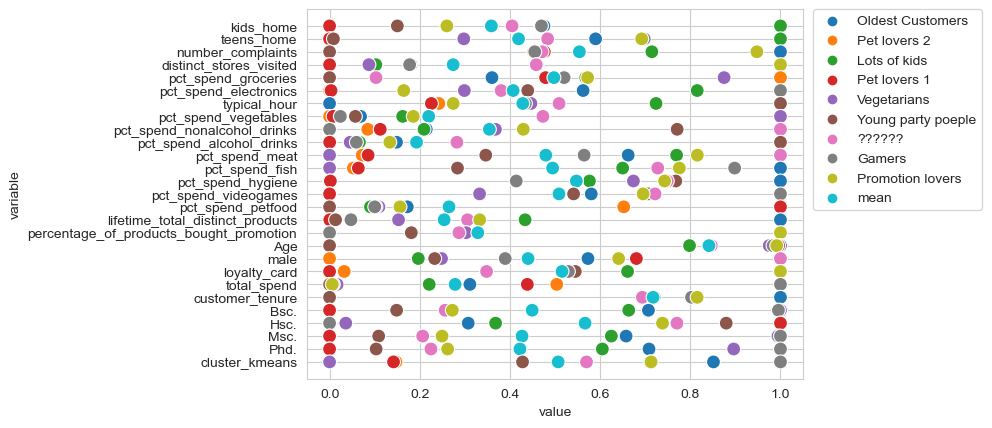

In [22]:
plot_comparing_avr_clusters(clusters_centroids_data=cluster_centroids_kmeans_adjust, colum_to_keep='cluster_kmeans_adjust')

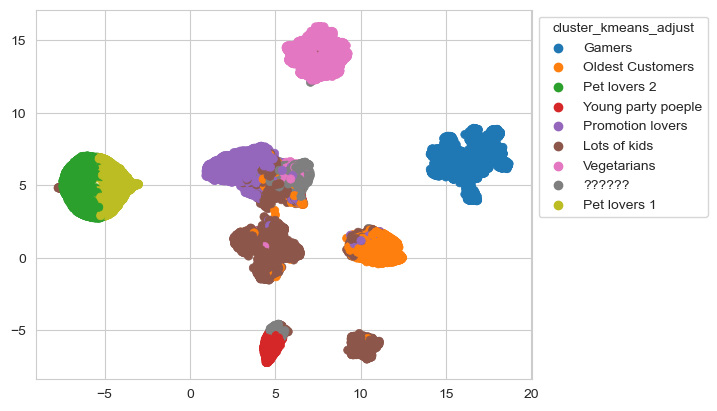

In [23]:
umap_adjust = umap.UMAP(n_neighbors = 10, random_state = 0).fit_transform(data_for_modelling_adjust_scaled)
visualize_dimensionality_reduction(umap_adjust, unclassified_data['cluster_kmeans_adjust'].apply(lambda row : d_kmeans_adjust[unclassified_data['cluster_kmeans_adjust'].value_counts()[row]]))

The UMAP dimensionality reduction on the model using the transformed data shows better separation than the original, but it's still not ideal, so we will try one more clustering solution, with the transformed data, before assigning clusters to any of our unclassified customers.

In [24]:
kmeans_adjust_7 = KMeans(n_clusters=7, random_state=0)
unclassified_data['cluster_kmeans_adjust_7'] =  kmeans_adjust_7.fit_predict(data_for_modelling_adjust_scaled)
unclassified_data['cluster_kmeans_adjust_7'].value_counts()


cluster_kmeans_adjust_7
6    10802
0     8484
3     7621
4     5647
5     5432
1     4147
2     1110
Name: count, dtype: int64

In [25]:
d_kmeans_adjust_7 = {10802 : 'Lots of kids', 8484 : 'Promotion lovers', 7621 : 'Vegetarians', 5647 : 'Gamers', 
          5432 : 'Oldest Customers', 4147 : 'Pet lovers', 1110 : 'Young party people'}
cluster_centroids_kmeans_adjust_7 = unclassified_data.drop(['customer_name', 'Final_Cluster'], axis = 1).groupby('cluster_kmeans_adjust_7').mean().reset_index()
cluster_centroids_kmeans_adjust_7['cluster_kmeans_adjust_7'] = cluster_centroids_kmeans_adjust_7['cluster_kmeans_adjust_7'].apply(lambda row : d_kmeans_adjust_7[unclassified_data['cluster_kmeans_adjust_7'].value_counts()[row]])
cluster_centroids_kmeans_adjust_7

,cluster_kmeans_adjust_7,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans,cluster_kmeans_adjust
0,Promotion lovers,0.60,0.95,0.93,3.03,35.01,4.49,12.48,4.37,6.50,6.31,7.72,8.98,8.98,7.33,10.64,387.99,46.55,54.96,0.51,0.72,5747.11,12.86,0.04,0.89,0.03,0.04,4.84,7.59
1,Pet lovers,0.00,0.01,0.51,1.00,45.43,0.78,11.87,0.98,2.45,0.20,1.00,1.00,0.40,0.01,47.81,51.86,19.86,55.30,0.49,0.20,21586.54,12.94,0.00,1.00,0.00,0.00,1.00,1.84
2,Young party people,0.36,0.08,0.09,1.44,15.29,9.41,18.22,2.27,9.64,37.83,3.74,3.98,9.51,5.94,2.53,92.49,14.88,27.11,0.50,0.48,5420.09,3.17,0.02,0.95,0.01,0.02,3.17,5.18
3,Vegetarians,1.00,0.44,0.51,1.21,48.53,6.60,13.73,16.54,5.15,2.25,0.54,0.57,8.23,3.57,8.33,213.97,20.08,54.90,0.49,0.49,6081.15,12.88,0.13,0.62,0.13,0.12,0.12,4.06
4,Gamers,1.00,1.00,0.50,1.39,35.54,20.20,13.63,1.30,1.56,2.63,5.22,10.40,5.20,10.44,7.84,100.53,6.94,55.22,0.50,0.50,39106.72,12.86,0.13,0.60,0.13,0.14,7.00,7.00
5,Oldest Customers,1.01,0.84,1.04,1.98,28.57,11.53,9.96,2.24,3.66,6.71,6.20,11.47,12.04,6.14,11.84,1053.10,19.61,55.83,0.50,0.76,15495.30,15.27,0.09,0.73,0.08,0.09,5.86,0.34
6,Lots of kids,2.12,1.41,0.75,1.22,37.56,16.56,16.21,3.47,3.55,2.92,6.99,7.58,7.02,7.34,7.31,496.26,20.05,49.50,0.49,0.57,12967.72,11.79,0.09,0.75,0.08,0.08,4.96,2.06


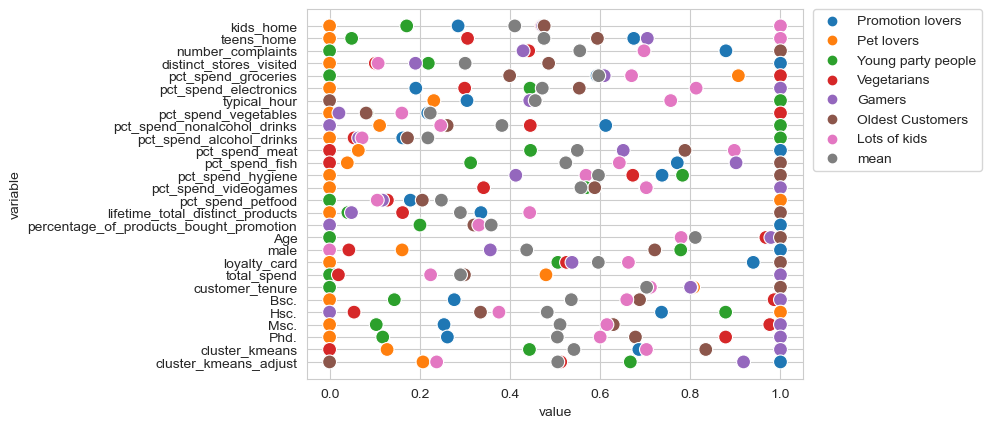

In [26]:
plot_comparing_avr_clusters(clusters_centroids_data=cluster_centroids_kmeans_adjust_7, colum_to_keep='cluster_kmeans_adjust_7')

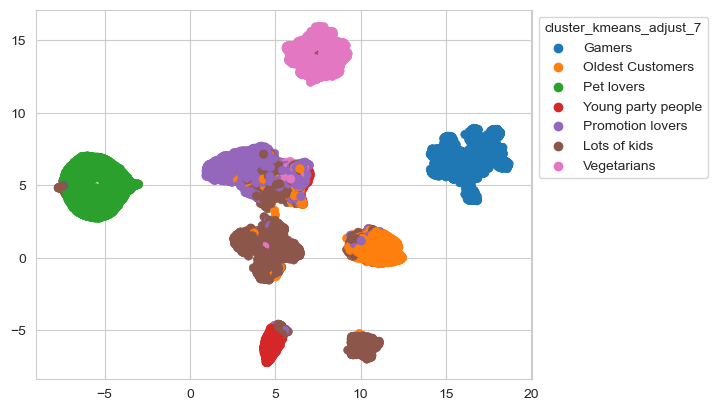

In [27]:
visualize_dimensionality_reduction(umap_adjust, unclassified_data['cluster_kmeans_adjust_7'].apply(lambda row : d_kmeans_adjust_7[unclassified_data['cluster_kmeans_adjust_7'].value_counts()[row]]))

Above is a run of the same model using 7 clusters instead of 9, where the results are slightly better but not ideal yet.

# Comparison of Kmeans

In [28]:
clustering_comparison_kmeans = unclassified_data.groupby(['cluster_kmeans_adjust_7','cluster_kmeans_adjust'])['Final_Cluster'].count().reset_index()

for name, n_observations in unclassified_data['cluster_kmeans_adjust_7'].value_counts().items():
    clustering_comparison_kmeans.loc[clustering_comparison_kmeans['cluster_kmeans_adjust_7'] == name, 'cluster_kmeans_adjust_7'] = d_kmeans_adjust_7[n_observations]

for name, n_observations in unclassified_data['cluster_kmeans_adjust'].value_counts().items():
    clustering_comparison_kmeans.loc[clustering_comparison_kmeans['cluster_kmeans_adjust'] == name, 'cluster_kmeans_adjust'] = d_kmeans_adjust[n_observations]

clustering_comparison_kmeans.set_index(['cluster_kmeans_adjust_7','cluster_kmeans_adjust'])

Final_Cluster
cluster_kmeans_adjust_7 cluster_kmeans_adjust               
Promotion lovers        Oldest Customers                  35
                        Lots of kids                     137
                        Vegetarians                        8
                        ??????                          1170
                        Promotion lovers                7134
Pet lovers              Pet lovers 2                    2398
                        Pet lovers 1                    1749
Young party people      Young party poeple               914
                        ??????                           196
Vegetarians             Oldest Customers                   1
                        Lots of kids                       1
                        Vegetarians                     7397
                        ??????                           222
Gamers                  Pet lovers 2                       3
                        Gamers                          5644
Oldest Customers        Oldest Customers                5095
                        Pet lovers 2                       1
                        Lots of kids                      51
                        ??????                           263
                        Promotion lovers                  22
Lots of kids            Oldest Customers                  16
                        Pet lovers 2                      70
                        Lots of kids                   10533
                        Vegetarians                        3
                        ??????                           152
                        Promotion lovers                  28

From the table above we can see that our models generally agree on the large majority of the observation of clusters, but there are some observations, specially for less defined groups, that are classified within different clusters by the models.

# Hierarchical Clustering - Ward Linkage


Before assigning final clusters to any of our unclassified customers, we will try an Agglomerative Hierarchical clustering using 'ward' linkage method fitted on the transformed data specified above. Firstly, we plot the dendrogram to find a good number of clusters.

In [29]:
#clustering_hierarchical_ward = (
#    AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage= 'ward')
#    .fit(data_for_modelling_adjust_scaled)
#)
# Plot our Dendrogram view

#fig, ax = plt.subplots()
#plt.title("Hierarchical Clustering Dendrogram (Ward)")
#plot_dendrogram(clustering_hierarchical_ward, truncate_mode="level")
#plt.show()

![](Hierarchical_ward_dendogram.png)

Looking at the dendrogram we believe that 7 clusters is an adequate cut point in this case.

In [30]:
unclassified_data['cluster_hierarchical_ward'] = AgglomerativeClustering(n_clusters=7, linkage= 'ward').fit_predict(data_for_modelling_adjust_scaled)

In [31]:
unclassified_data['cluster_hierarchical_ward'].value_counts()

cluster_hierarchical_ward
1    10838
4     9513
6     7078
5     5642
2     4949
0     4241
3      982
Name: count, dtype: int64

In [32]:
d_ward = {4241 : 'Pet lovers', 10838 : 'Promotion lovers', 4949 : 'Oldest Customers', 982 : 'Young party people', 
          9513 : 'Lots of kids', 5642 : 'Gamers', 7078 : 'Vegetarians'}
cluster_centroids_hierarquical_ward = unclassified_data.drop(['customer_name', 'Final_Cluster'], axis = 1).groupby('cluster_hierarchical_ward').mean().reset_index()
cluster_centroids_hierarquical_ward['cluster_hierarchical_ward'] = cluster_centroids_hierarquical_ward['cluster_hierarchical_ward'].apply(lambda row : d_ward[unclassified_data['cluster_hierarchical_ward'].value_counts()[row]])
cluster_centroids_hierarquical_ward

,cluster_hierarchical_ward,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans,cluster_kmeans_adjust,cluster_kmeans_adjust_7
0,Pet lovers,0.00,0.01,0.50,1.00,46.10,0.78,11.86,0.98,2.46,0.20,1.00,1.00,0.39,0.00,47.14,51.71,19.88,55.33,0.49,0.20,21527.46,12.95,0.00,1.00,0.00,0.00,1.03,1.83,1.11
1,Promotion lovers,0.67,0.93,0.91,2.72,34.13,5.13,12.76,5.16,6.25,6.82,7.72,8.83,8.96,7.26,10.08,403.48,40.48,55.09,0.50,0.67,5907.73,12.79,0.03,0.90,0.03,0.04,4.50,6.60,1.11
2,Oldest Customers,1.01,0.83,1.00,2.02,29.33,12.12,9.54,1.79,3.55,5.96,5.93,11.76,12.01,5.98,11.96,1059.48,20.10,54.65,0.50,0.80,16865.94,15.31,0.10,0.70,0.09,0.10,5.80,0.25,4.97
3,Young party people,0.30,0.00,0.00,1.35,15.24,9.53,18.87,1.76,10.10,39.19,3.35,3.49,9.63,5.83,1.99,53.65,14.20,24.02,0.49,0.50,5399.13,2.24,0.02,0.95,0.02,0.02,3.11,5.11,1.97
4,Lots of kids,2.29,1.50,0.76,1.19,37.03,17.76,16.57,3.38,3.41,2.63,6.98,7.50,6.96,7.43,7.21,525.95,20.02,49.08,0.49,0.58,13454.18,11.75,0.10,0.73,0.09,0.09,5.27,2.00,5.95
5,Gamers,1.00,1.00,0.50,1.39,35.52,20.20,13.63,1.30,1.56,2.63,5.22,10.41,5.21,10.45,7.83,100.58,6.94,55.22,0.50,0.50,39119.82,12.86,0.13,0.60,0.13,0.14,7.00,7.00,4.00
6,Vegetarians,1.00,0.42,0.51,1.16,50.25,6.57,13.73,16.46,5.01,1.94,0.03,0.05,8.26,3.37,8.37,201.99,20.21,55.06,0.50,0.50,6064.00,12.93,0.14,0.60,0.13,0.13,0.00,4.00,3.01


Above we can see the dataframe corresponding to the centroids of our clusters, a dictionary is used to link the output of AgglomerativeClustering to interpretable names for clusters. A more detailed plot comparing different cluster means to overal means for all variables is available below and allows us to get a better understanding of the defining characteristic of our clusters and thus their names.

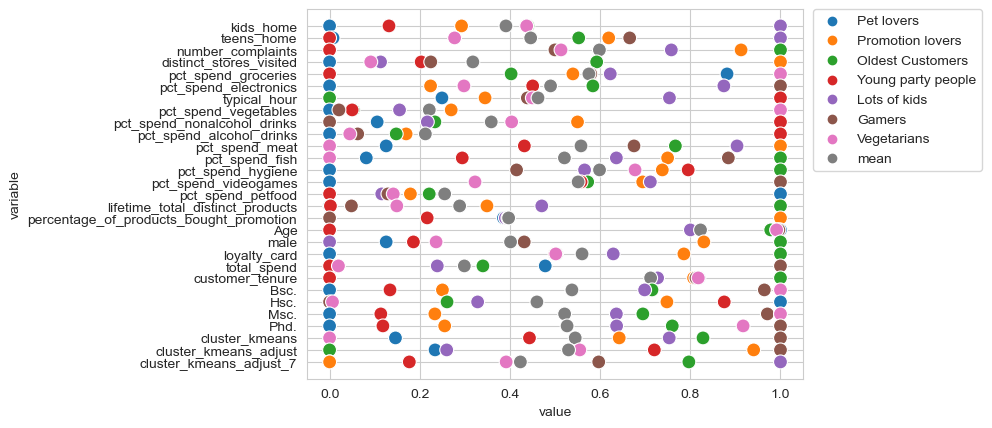

In [33]:
plot_comparing_avr_clusters(clusters_centroids_data = cluster_centroids_hierarquical_ward, colum_to_keep = 'cluster_hierarchical_ward')

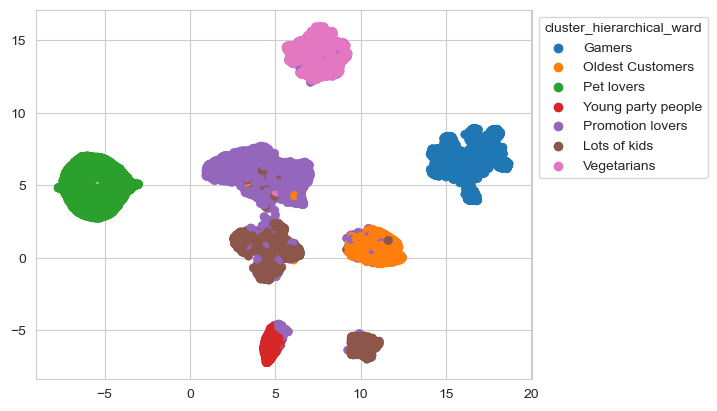

In [34]:
visualize_dimensionality_reduction(umap_adjust, unclassified_data['cluster_hierarchical_ward'].apply(lambda row : d_ward[unclassified_data['cluster_hierarchical_ward'].value_counts()[row]]))

Looking at the UMAP dimensionality reduction, it is clear that this model provides us with the best cluestering division out of the models we tested.

# Comparison of Kmeans with Hierarquical

In [35]:
clustering_comparison_kmean_hierarquical = unclassified_data.groupby(['cluster_hierarchical_ward', 'cluster_kmeans_adjust_7'])['Final_Cluster'].count().reset_index()

for name, n_observations in unclassified_data['cluster_hierarchical_ward'].value_counts().items():
    clustering_comparison_kmean_hierarquical.loc[clustering_comparison_kmean_hierarquical['cluster_hierarchical_ward'] == name, 'cluster_hierarchical_ward'] = d_ward[n_observations]

for name, n_observations in unclassified_data['cluster_kmeans_adjust_7'].value_counts().items():
    clustering_comparison_kmean_hierarquical.loc[clustering_comparison_kmean_hierarquical['cluster_kmeans_adjust_7'] == name, 'cluster_kmeans_adjust_7'] = d_kmeans_adjust_7[n_observations]

clustering_comparison_kmean_hierarquical.set_index(['cluster_hierarchical_ward', 'cluster_kmeans_adjust_7'])

Final_Cluster
cluster_hierarchical_ward cluster_kmeans_adjust_7               
Pet lovers                Pet lovers                        4143
                          Gamers                               3
                          Lots of kids                        95
Promotion lovers          Promotion lovers                  8325
                          Pet lovers                           4
                          Young party people                 149
                          Vegetarians                        559
                          Oldest Customers                   705
                          Lots of kids                      1096
Oldest Customers          Promotion lovers                    83
                          Gamers                               3
                          Oldest Customers                  4605
                          Lots of kids                       258
Young party people        Promotion lovers                    19
                          Young party people                 961
                          Lots of kids                         2
Lots of kids              Promotion lovers                    57
                          Vegetarians                          3
                          Gamers                               1
                          Oldest Customers                   122
                          Lots of kids                      9330
Gamers                    Gamers                            5640
                          Lots of kids                         2
Vegetarians               Vegetarians                       7059
                          Lots of kids                        19

Looking at the Dataframe, we can see that generally the models are splitting observations in similar ways, again with some more divergence in less defined regions. For this reason, and also looking back to the dimensionality reduction of the ward hierarchical model, we will define the final cluster as the ward hierarchical cluster for the following clusters: 'Pet lovers’, ‘Gamers', 'Vegetarians', 'Young party people'. We will, subsequently, add the newly classified customers to our classified_data and remove them from unclassified_data. We will also remove them from both our modelling datasets. As for the remaining customers that haven't been classified a deeper analysis will be performed to find an effective method of splitting them into groups. We're also going to re-run the UMAP dimensionality reduction as we have significantly changed our data.

In [36]:
for name, n_observations in unclassified_data['cluster_hierarchical_ward'].value_counts().items():
    if d_ward[n_observations] in ['Pet lovers', 'Gamers', 'Vegetarians', 'Young party people']:
        unclassified_data.loc[unclassified_data['cluster_hierarchical_ward'] == name, 'Final_Cluster'] = d_ward[n_observations]

In [37]:
unclassified_data['Final_Cluster'].value_counts()

Final_Cluster
Unspecified           25300
Vegetarians            7078
Gamers                 5642
Pet lovers             4241
Young party people      982
Name: count, dtype: int64

In [38]:
cluster_vars = list(unclassified_data.columns[unclassified_data.columns.str.startswith('cluster')])
classified_data = pd.concat([classified_data, unclassified_data[unclassified_data.Final_Cluster != 'Unspecified'].drop(cluster_vars, axis = 1)])

In [39]:
classified_data.Final_Cluster.value_counts()

Final_Cluster
Vegetarians           7078
Gamers                5642
Pet lovers            4241
Young party people     982
Fishermen              388
Name: count, dtype: int64

In [40]:
unclassified_data = unclassified_data[unclassified_data.Final_Cluster == 'Unspecified'].copy()

In [41]:
data_for_modelling = data_for_modelling[data_for_modelling.index.isin(unclassified_data.index)]
data_for_modelling_adjust_scaled = data_for_modelling_adjust_scaled[data_for_modelling_adjust_scaled.index.isin(unclassified_data.index)]


In [42]:
umap_2_adjust = umap.UMAP(n_neighbors = 10, random_state = 0).fit_transform(data_for_modelling_adjust_scaled) 

# Meanshift

After applying models like KMeans and Hierarchical clustering which are generally good and finding well-defined spherical clusters and finding the appropriate cluster for a sizeable portion of customers, we will now try to divide the remaining customers adequately using density-based clustering solutions. The first one we will test is Meanshift.

In [43]:
bandwidth_est = estimate_bandwidth(data_for_modelling_adjust_scaled, n_jobs=-1)
bandwidth_est

4.07283115825543

In [44]:
meanshift = MeanShift(bandwidth=4.25, n_jobs=-1, bin_seeding=True)
unclassified_data['cluster_ms'] = meanshift.fit_predict(data_for_modelling_adjust_scaled)

In [45]:
unclassified_data['cluster_ms'].value_counts()

cluster_ms
0    25176
1      106
2       18
Name: count, dtype: int64

In [46]:
cluster_centroids_ms = unclassified_data.drop(['customer_name', 'Final_Cluster'], axis = 1).groupby('cluster_ms').mean().reset_index()
cluster_centroids_ms

,cluster_ms,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans,cluster_kmeans_adjust,cluster_kmeans_adjust_7,cluster_hierarchical_ward
0,0,1.35,1.12,0.87,2.01,34.40,11.26,13.56,3.80,4.65,4.99,7.09,8.91,8.79,7.07,9.37,578.55,28.83,52.73,0.50,0.66,10916.79,12.90,0.07,0.80,0.06,0.07,5.05,3.62,3.69,2.33
1,1,0.80,0.72,0.80,2.34,10.12,8.83,13.73,10.00,5.51,25.75,7.14,7.56,8.07,7.65,9.99,428.42,23.32,55.04,0.48,0.41,5346.53,11.88,0.06,0.87,0.04,0.04,3.70,5.72,2.20,1.00
2,2,0.78,0.50,0.44,1.89,5.43,9.15,12.62,10.90,10.12,7.08,5.56,4.28,33.50,7.02,8.13,488.39,19.57,62.61,0.61,0.33,4402.39,12.61,0.00,1.00,0.00,0.00,4.00,4.44,3.28,1.00


Tryning various bandwidths around the estimated value never yields any valuable results. 

# DBSCAN

The other density-based clustering algorithm we will test is DBSCAN. 

In [47]:
dbscan = DBSCAN(eps=1.55, min_samples=10, n_jobs=-1)
unclassified_data['cluster_dbscan'] = dbscan.fit_predict(data_for_modelling_adjust_scaled)

In [48]:
unclassified_data['cluster_dbscan'].value_counts()

cluster_dbscan
-1    14530
 0     8938
 1     1811
 4       10
 3        7
 2        4
Name: count, dtype: int64

In [49]:
d_dbscan = {i: i if i != 0 else 'Kids' for i in unclassified_data['cluster_dbscan'].unique()}
cluster_centroids_dbscan = unclassified_data.drop(['customer_name', 'Final_Cluster'], axis = 1).groupby('cluster_dbscan').mean().reset_index()
cluster_centroids_dbscan['cluster_dbscan'] = cluster_centroids_dbscan['cluster_dbscan'].apply(lambda row : d_dbscan[row])
cluster_centroids_dbscan

,cluster_dbscan,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans,cluster_kmeans_adjust,cluster_kmeans_adjust_7,cluster_hierarchical_ward,cluster_ms
0,-1,0.87,0.90,0.90,2.41,33.11,7.94,12.48,4.37,5.41,6.30,7.32,9.33,9.41,7.06,10.13,578.71,32.92,53.33,0.50,0.64,8941.36,12.86,0.05,0.85,0.05,0.05,4.71,4.62,2.57,1.58,0.01
1,Kids,2.39,1.70,1.00,1.50,36.06,13.14,15.28,3.32,3.95,3.41,7.18,8.61,8.60,7.14,8.86,584.86,23.81,56.33,0.50,0.72,13288.17,13.90,0.08,0.78,0.07,0.07,6.20,2.34,5.04,3.19,0.00
2,1,0.08,0.00,0.01,1.27,34.88,28.54,13.78,2.05,2.07,3.43,4.79,6.86,4.96,6.87,5.80,534.76,20.23,30.50,0.49,0.50,14688.88,8.25,0.17,0.50,0.17,0.17,2.00,2.00,6.00,4.00,0.00
3,2,0.00,1.00,1.00,2.00,34.07,3.84,12.75,3.93,6.93,5.83,10.70,10.79,4.19,8.40,12.26,594.50,30.26,43.00,0.75,1.00,5765.50,12.25,0.00,0.75,0.25,0.00,5.00,8.00,0.00,1.75,0.00
4,3,1.00,1.29,0.86,2.00,29.22,10.18,8.71,1.61,3.32,7.49,7.32,11.60,12.56,5.19,11.77,1289.57,18.65,28.57,0.00,0.86,17097.00,5.57,0.00,0.86,0.00,0.14,6.00,0.00,5.00,2.00,0.00
5,4,0.00,1.20,1.00,4.10,38.27,3.39,12.00,2.98,5.64,5.00,6.22,10.83,8.44,9.61,9.62,360.70,76.82,52.60,0.10,0.90,5523.50,16.10,0.10,0.70,0.20,0.00,5.00,8.00,0.00,1.00,0.00


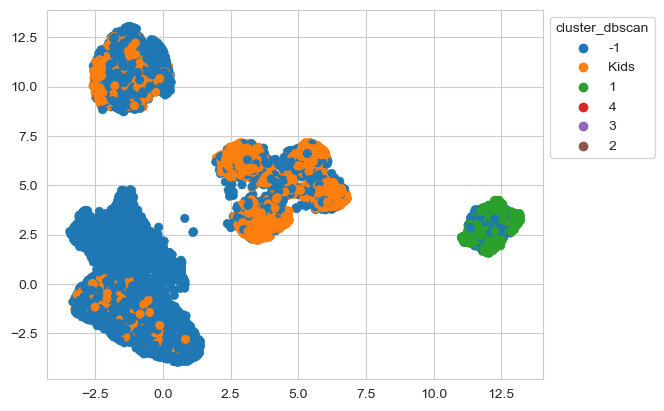

In [50]:
visualize_dimensionality_reduction(umap_2_adjust, unclassified_data['cluster_dbscan'].apply(lambda row : d_dbscan[row]))

We can conclude after an evaluation of parameter combinations that DBSCAN isn't able to approprietaly cluster our remaining data. 

Based on these two algorithms, we can cleary see that our clusters are spherically-shaped, since density-based models are not able to produce good results, so we will keep trying with more appropriate models for that type of clusters.

# SOM

The next model we're gonna test is SOM.

In [51]:
som = MiniSom(
    3,
    3,
    input_len = len(data_for_modelling_adjust_scaled.columns),
    sigma=0.5,
    learning_rate=1,
    neighborhood_function='gaussian',
    random_seed=0
    )

In [52]:
# Set the seed of Numpy just to be sure of replicability
np.random.seed(0)

num_iterations = 1000

q_errors = []
for i in range(1, num_iterations):
    som.train_batch(data_for_modelling_adjust_scaled.values, i)
    q_errors.append(som.quantization_error(data_for_modelling_adjust_scaled.values))

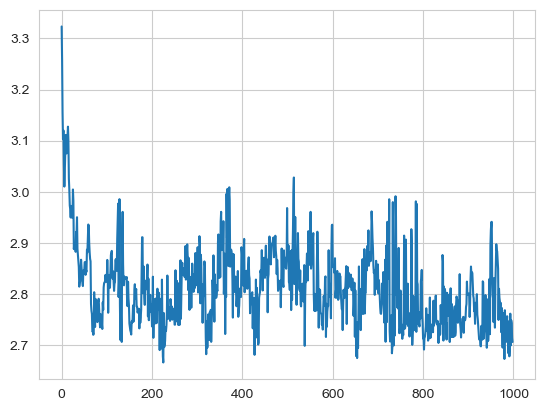

In [53]:
plt.plot(q_errors)

Analysing the q_errors plot it becomes clear that to ensure the best results possible we should use 1000 iterations.

In [54]:
som = MiniSom(
    3,
    3,
    input_len = len(data_for_modelling_adjust_scaled.columns),
    sigma=0.5,
    learning_rate=1,
    neighborhood_function='gaussian',
    random_seed=0)

som.train(data_for_modelling_adjust_scaled.values, 1000)

In [55]:
unclassified_data['som_winner_node'] = (
    [som.winner(data_for_modelling_adjust_scaled.values[i]) for i in range(0, len(data_for_modelling_adjust_scaled))]
)

In [56]:
unclassified_data['som_winner_node'].value_counts()

som_winner_node
(0, 0)    7557
(2, 2)    4162
(2, 0)    3630
(1, 0)    2947
(1, 1)    2478
(1, 2)    1998
(0, 2)    1011
(0, 1)     773
(2, 1)     744
Name: count, dtype: int64

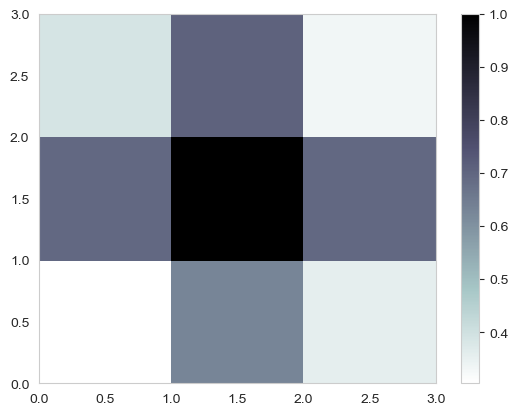

In [57]:
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

In [58]:
cluster_centroids_som = unclassified_data.drop(['customer_name', 'Final_Cluster'], axis = 1).groupby('som_winner_node').mean().reset_index()

cluster_centroids_som

,som_winner_node,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans,cluster_kmeans_adjust,cluster_kmeans_adjust_7,cluster_hierarchical_ward,cluster_ms,cluster_dbscan
0,"(0, 0)",2.85,1.89,0.98,1.13,38.20,13.97,17.33,3.85,3.86,2.46,7.64,7.70,7.52,7.48,7.61,509.18,20.02,55.05,0.49,0.59,12838.75,13.02,0.07,0.81,0.06,0.06,6.06,2.00,5.95,3.75,0.00,-0.22
1,"(0, 1)",0.96,0.82,1.22,2.07,29.05,8.40,14.23,5.98,3.87,17.25,7.74,7.48,7.77,6.07,6.76,402.37,22.50,57.51,0.49,0.40,7213.29,12.49,0.03,0.93,0.02,0.02,4.11,4.87,2.80,1.01,0.12,-1.00
2,"(0, 2)",0.93,0.76,0.48,2.20,20.54,7.64,13.67,14.67,7.15,6.83,8.75,8.78,8.68,8.11,9.19,388.82,18.12,54.21,0.49,0.41,5945.25,12.77,0.04,0.88,0.04,0.04,2.99,5.20,2.25,1.04,0.02,-1.00
3,"(1, 0)",0.98,0.82,0.97,2.00,29.79,11.88,9.52,1.81,3.53,6.03,5.85,11.74,11.89,5.94,11.95,1470.27,20.04,55.14,0.50,0.79,16877.61,15.56,0.10,0.72,0.08,0.09,5.99,0.01,5.00,1.99,0.00,-0.64
4,"(1, 1)",0.28,0.11,0.06,1.38,34.79,27.09,13.84,2.19,2.21,3.55,5.01,7.12,5.29,7.07,5.95,569.65,20.30,30.28,0.51,0.51,14297.98,7.84,0.16,0.53,0.16,0.15,2.22,1.97,5.97,3.90,0.00,0.48
5,"(1, 2)",0.51,1.00,0.99,4.59,37.51,3.67,12.12,3.61,5.61,5.22,7.51,9.10,9.62,7.71,10.78,403.93,59.09,52.29,0.53,0.80,5470.68,12.16,0.04,0.89,0.03,0.04,5.00,8.00,0.00,1.00,0.00,-0.86
6,"(2, 0)",0.57,0.99,0.96,2.24,38.29,3.93,12.41,4.23,6.12,5.67,7.19,8.78,8.00,6.75,11.37,412.35,55.15,54.74,0.52,0.77,5590.19,13.03,0.03,0.90,0.03,0.03,4.89,7.62,0.25,1.03,0.00,-0.83
7,"(2, 1)",0.85,0.69,0.46,1.97,20.83,8.13,14.07,5.38,15.24,9.88,9.13,8.57,9.29,7.21,6.80,374.17,19.53,51.10,0.55,0.39,5748.22,11.40,0.02,0.92,0.02,0.04,3.97,5.94,1.12,1.00,0.03,-1.00
8,"(2, 2)",0.85,0.93,1.05,2.49,31.70,8.40,10.87,2.66,4.26,5.93,7.04,10.49,11.48,7.03,11.35,418.30,23.93,57.76,0.47,0.77,11102.83,14.38,0.06,0.79,0.07,0.08,5.24,3.54,3.02,1.58,0.00,-0.73


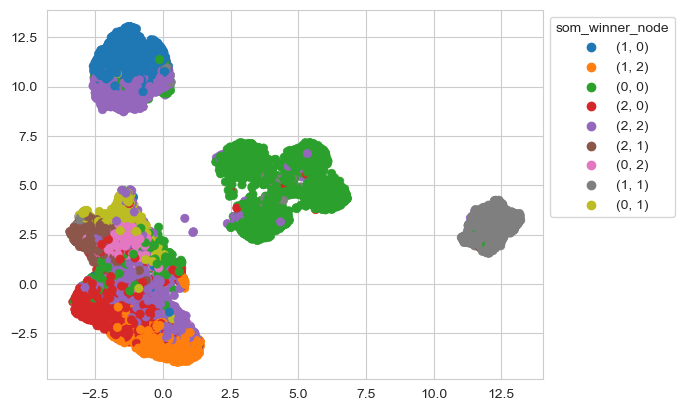

In [59]:
visualize_dimensionality_reduction(umap_2_adjust, unclassified_data['som_winner_node'])

The different visualizations and DataFrames above allow us to conclude that the SOM model isn't able to really find differences between clusters, except for the gray cluster in the UMAP dimensionality reduction.

# K-Means

As we have established that simpler techniques which are good at finding spherical clusters are required to adequately cluster the remaining customers in our data, we will start by using KMeans once again. We are going to repeat the process in the same way as before, using the elbow plot to find an adequate k.

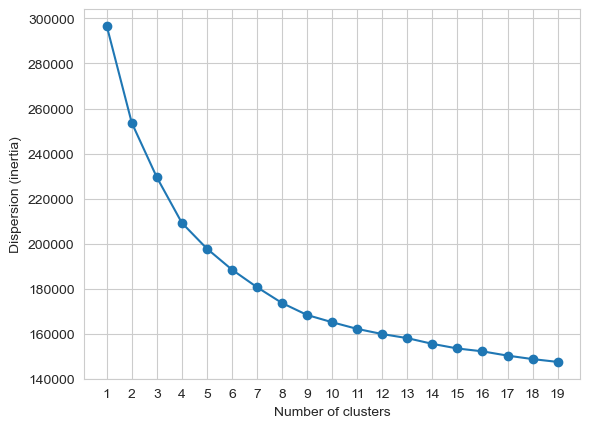

In [60]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data_for_modelling_adjust_scaled)
    dispersion.append(kmeans.inertia_)
plt.plot(range(1, 20), dispersion, marker='o')
plt.xticks(range(1, 20))
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

We choose k=5 because it allows us to reduce complexity and also because in the in the UMAP dimensionality reduction (available in some of the above models) there are only 4 clear groups of points and thus it makes no sense to go much higher than 4.

In [61]:
kmeans_adjust_2 = KMeans(n_clusters=5, random_state=0)
unclassified_data['cluster_kmeans_adjust_2'] = kmeans_adjust_2.fit_predict(data_for_modelling_adjust_scaled)

In [62]:
kmeans_adjust_2.inertia_

197757.16262017333

In [63]:
unclassified_data['cluster_kmeans_adjust_2'].value_counts()

cluster_kmeans_adjust_2
2    8648
0    6908
3    4907
1    2594
4    2243
Name: count, dtype: int64

In [64]:
d_kmeans_adjust_2 = {6908 : 'Promotion lovers', 4907 : 'Oldest Customers', 2594 : 'Young, lots of electronics', 
                     2243 : '??????', 8648 : 'Lots of kids'}
cluster_centroids_kmeans_adjust_2 = unclassified_data.drop(['customer_name', 'Final_Cluster', 'som_winner_node'], axis = 1).groupby('cluster_kmeans_adjust_2').mean().reset_index()
cluster_centroids_kmeans_adjust_2['cluster_kmeans_adjust_2'] = cluster_centroids_kmeans_adjust_2['cluster_kmeans_adjust_2'].apply(lambda row : d_kmeans_adjust_2[unclassified_data['cluster_kmeans_adjust_2'].value_counts()[row]])
cluster_centroids_kmeans_adjust_2

,cluster_kmeans_adjust_2,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans,cluster_kmeans_adjust,cluster_kmeans_adjust_7,cluster_hierarchical_ward,cluster_ms,cluster_dbscan
0,Promotion lovers,0.55,0.99,1.00,3.24,37.64,3.94,12.18,3.80,5.60,5.66,7.34,9.01,9.04,7.26,11.04,395.61,51.22,55.27,0.51,0.78,5714.81,12.99,0.04,0.89,0.03,0.04,4.98,7.97,0.04,1.03,0.00,-0.84
1,"Young, lots of electronics",0.32,0.14,0.09,1.39,34.73,26.66,13.89,2.23,2.26,3.64,5.10,7.20,5.41,7.03,6.01,553.70,20.21,30.16,0.49,0.51,14182.38,7.74,0.16,0.54,0.15,0.15,2.26,2.00,5.96,3.85,0.00,0.43
2,Lots of kids,2.61,1.78,0.99,1.19,38.08,13.03,16.68,3.91,3.97,2.85,7.60,7.81,7.77,7.46,7.81,480.44,20.75,55.92,0.49,0.60,12302.95,13.15,0.07,0.82,0.06,0.06,5.77,2.17,5.67,3.44,0.00,-0.30
3,Oldest Customers,1.00,0.84,1.03,2.02,29.12,11.76,9.67,1.92,3.56,6.25,6.03,11.63,12.09,6.02,12.02,1106.14,19.90,55.55,0.50,0.78,16203.41,15.45,0.10,0.72,0.09,0.10,5.97,0.01,4.98,1.97,0.00,-0.64
4,??????,0.90,0.75,0.56,2.04,20.06,7.91,13.91,9.67,9.56,10.94,8.95,8.76,8.83,7.39,8.36,386.91,20.25,52.70,0.51,0.40,5935.81,11.96,0.04,0.90,0.03,0.03,3.64,5.67,1.81,1.01,0.06,-1.00


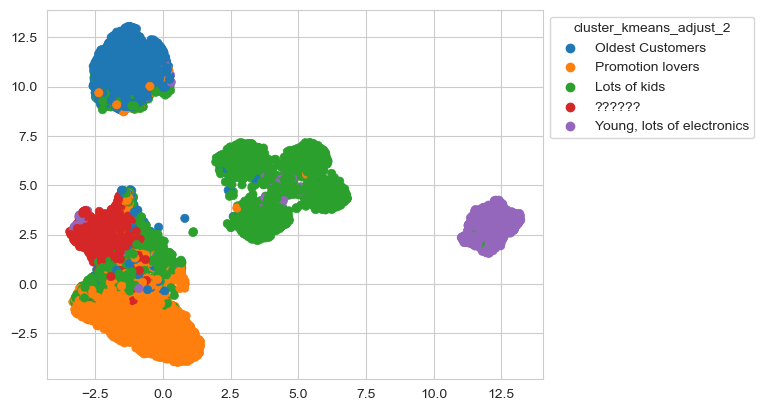

In [65]:
visualize_dimensionality_reduction(umap_2_adjust, unclassified_data['cluster_kmeans_adjust_2'].apply(lambda row : d_kmeans_adjust_2[unclassified_data['cluster_kmeans_adjust_2'].value_counts()[row]]))

As we saw with SOM, KMeans singles out a group of points despite providing, in general, bad results. For this reason we will assign to those observations their final cluster and repeat the process of moving them from one dataset to another, then re-filtering the modelling datasets and re-doing the UMAP dimensionality reduction.

In [66]:
for name, n_observations in unclassified_data['cluster_kmeans_adjust_2'].value_counts().items():
    if d_kmeans_adjust_2[n_observations] == 'Young, lots of electronics':
        unclassified_data.loc[unclassified_data['cluster_kmeans_adjust_2'] == name, 'Final_Cluster'] = d_kmeans_adjust_2[n_observations]

In [67]:
unclassified_data['Final_Cluster'].value_counts()

Final_Cluster
Unspecified                   22706
Young, lots of electronics     2594
Name: count, dtype: int64

In [68]:
cluster_vars = list(unclassified_data.columns[unclassified_data.columns.str.startswith('cluster')]) + ['som_winner_node']
classified_data = pd.concat([classified_data, unclassified_data[unclassified_data.Final_Cluster != 'Unspecified'].drop(cluster_vars, axis = 1)])

In [69]:
classified_data.Final_Cluster.value_counts()

Final_Cluster
Vegetarians                   7078
Gamers                        5642
Pet lovers                    4241
Young, lots of electronics    2594
Young party people             982
Fishermen                      388
Name: count, dtype: int64

In [70]:
unclassified_data = unclassified_data[unclassified_data.Final_Cluster == 'Unspecified'].copy()

In [71]:
data_for_modelling = data_for_modelling[data_for_modelling.index.isin(unclassified_data.index)]
data_for_modelling_adjust_scaled = data_for_modelling_adjust_scaled[data_for_modelling_adjust_scaled.index.isin(unclassified_data.index)]


In [72]:
umap_adjust_3 = umap.UMAP(n_neighbors = 10, random_state = 0).fit_transform(data_for_modelling_adjust_scaled) 

# Hierarchical Clustering

We are now going to use Agglomerative Hierarchical clustering using ward linkage again. We will use the dendogram to find the optimal number of clusters which remain uncovered inour data.

In [73]:
#clustering_hierarchical_ward = (
#   AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage= 'ward')
#   .fit(data_for_modelling_adjust_scaled)
#)
#Plot our Dendrogram view

#fig, ax = plt.subplots()
#plt.title("Hierarchical Clustering Dendrogram (Ward)")
#plot_dendrogram(clustering_hierarchical_ward, truncate_mode="level")
#plt.show()

![](Hierarchical_ward_dendogram2.png)

Despite the dendogram showing us that 4 clusters is the right number, after testing both, 3 actually provides better results and it also coincides with the number of groups left in the UMAP dimensionality reduction.

In [74]:
unclassified_data['cluster_hierarchical_ward_2'] = AgglomerativeClustering(n_clusters=3, linkage= 'ward').fit_predict(data_for_modelling_adjust_scaled)

In [75]:
unclassified_data['cluster_hierarchical_ward_2'].value_counts()

cluster_hierarchical_ward_2
0    10962
2     6867
1     4877
Name: count, dtype: int64

In [76]:
d_ward_2 = {10962 : 'Promotions', 6867 : 'Parents', 4877 : 'Loyal Customers'}
cluster_centroids_hierarquical_ward_2 = unclassified_data.drop(['customer_name', 'Final_Cluster', 'som_winner_node'], axis = 1).groupby('cluster_hierarchical_ward_2').mean().reset_index()
cluster_centroids_hierarquical_ward_2['cluster_hierarchical_ward_2'] = cluster_centroids_hierarquical_ward_2['cluster_hierarchical_ward_2'].apply(lambda row : d_ward_2[unclassified_data['cluster_hierarchical_ward_2'].value_counts()[row]])
cluster_centroids_hierarquical_ward_2

,cluster_hierarchical_ward_2,kids_home,teens_home,number_complaints,distinct_stores_visited,pct_spend_groceries,pct_spend_electronics,typical_hour,pct_spend_vegetables,pct_spend_nonalcohol_drinks,pct_spend_alcohol_drinks,pct_spend_meat,pct_spend_fish,pct_spend_hygiene,pct_spend_videogames,pct_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,Age,male,loyalty_card,total_spend,customer_tenure,Bsc.,Hsc.,Msc.,Phd.,cluster_kmeans,cluster_kmeans_adjust,cluster_kmeans_adjust_7,cluster_hierarchical_ward,cluster_ms,cluster_dbscan,cluster_kmeans_adjust_2
0,Promotions,0.68,0.94,0.92,2.71,34.13,5.10,12.73,5.14,6.23,6.76,7.75,8.84,8.97,7.27,10.14,404.98,40.25,55.22,0.50,0.67,5967.65,12.83,0.03,0.90,0.03,0.04,4.52,6.55,1.14,1.07,0.01,-0.88,1.19
1,Loyal Customers,1.02,0.83,1.00,2.02,29.35,12.08,9.54,1.79,3.56,5.96,5.94,11.78,12.00,5.99,11.97,1071.76,20.09,55.16,0.51,0.80,16875.32,15.50,0.10,0.70,0.09,0.10,5.86,0.22,4.96,2.02,0.00,-0.61,2.90
2,Parents,3.04,2.00,1.00,1.11,37.87,14.65,17.62,3.80,3.82,2.29,7.60,7.60,7.55,7.54,7.57,512.17,19.96,55.61,0.49,0.60,13248.83,13.09,0.07,0.80,0.06,0.06,6.36,1.99,5.98,3.97,0.00,-0.16,2.00


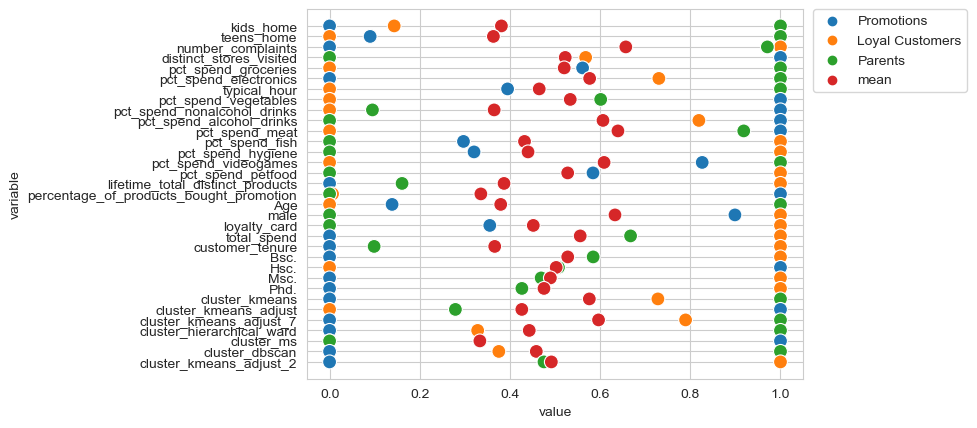

In [77]:
plot_comparing_avr_clusters(clusters_centroids_data = cluster_centroids_hierarquical_ward_2, colum_to_keep = 'cluster_hierarchical_ward_2')

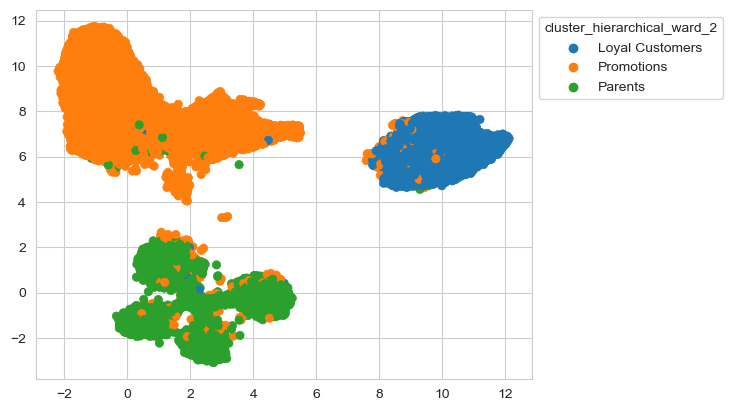

In [78]:
visualize_dimensionality_reduction(umap_adjust_3, unclassified_data['cluster_hierarchical_ward_2'].apply(lambda row : d_ward_2[unclassified_data['cluster_hierarchical_ward_2'].value_counts()[row]]))

Despite this still not being a perfect solution, we will finalize these clusters as it is the best solution we have been able to find. We will repeat the process as explained before.

In [79]:
for name, n_observations in unclassified_data['cluster_hierarchical_ward_2'].value_counts().items():
        unclassified_data.loc[unclassified_data['cluster_hierarchical_ward_2'] == name, 'Final_Cluster'] = d_ward_2[n_observations]

In [80]:
unclassified_data['Final_Cluster'].value_counts()

Final_Cluster
Promotions         10962
Parents             6867
Loyal Customers     4877
Name: count, dtype: int64

In [81]:
cluster_vars = list(unclassified_data.columns[unclassified_data.columns.str.startswith('cluster')]) + ['som_winner_node']
classified_data = pd.concat([classified_data, unclassified_data[unclassified_data.Final_Cluster != 'Unspecified'].drop(cluster_vars, axis = 1)])

In [82]:
len(classified_data)

43631

We will now use a RandomForest to estimate which of our variables have more impact in the separation of our clusters.

In [83]:
model_final=RandomForestClassifier(random_state = 0)

model_fited =  model_final.fit(classified_data.drop(['customer_name', 'Final_Cluster'],axis=1), classified_data.Final_Cluster)

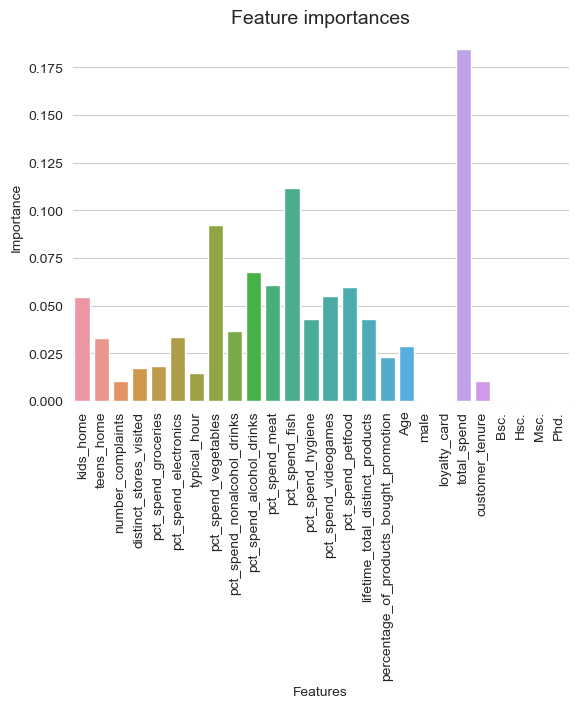

In [84]:
# Creating importances_df dataframe
importances_df = pd.DataFrame({"feature_names" : list(classified_data.drop(['customer_name', 'Final_Cluster'],axis=1).columns),
                               "importances" : model_final.feature_importances_})

# Plotting bar chart, g is from graph
fig = sns.barplot(x=importances_df["feature_names"],
                y=importances_df["importances"])
fig.set_title("Feature importances", fontsize=14)
sns.despine(bottom=True, left=True)
plt.xticks(rotation=90)
fig.set(xlabel='Features', ylabel='Importance')
plt.show()

We can see that the importance is relatively balanced, with a couple of spikes, in total_spend and pct_spend_fish. This can be attributed to the 'Fishermen' cluster which has the highest total_spend of all clusters and has an average pct_spend_fish greater than 70%, but is the smallest cluster. We can also see that the gender and loyalty card variables have essentially no importance, as well as the education variables, which makes sense as these weren't used for clustering. The purchase behaviour variables show a decent amount of importance, specially vegetables, which also makes sense from the vegetarians cluster.

Now that we have assigned a final cluster to all of our observations, we will export our classified data and move on to the next notebook 'Project_cluster_analysis' where we will perform an analysis of our clusters.

In [85]:
%cd ..
classified_data.to_csv('datasets/Final_classified_data.csv')

c:\Users\luisb\OneDrive\Documentos\uni\Year 2\Semester 2\Machine learning 2\ML2_project
